In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor 
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
data_dir = "https://raw.githubusercontent.com/rroggenk/DATA301/main/"

In [ ]:
df_flying_etiquette = pd.read_csv(data_dir + "flying-etiquette.csv")
df_flying_etiquette = df_flying_etiquette[df_flying_etiquette["How often do you travel by plane?"] != "Never"]

In [ ]:
df_international_tourism = pd.read_csv(data_dir + "df_international_tourism.csv")
df_international_tourism = df_international_tourism[df_international_tourism["year"] >= 1995]

#Slide 4: Flying Etiquette Data

In [ ]:
df_flying_etiquette.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 1039
Data columns (total 27 columns):
 #   Column                                                                                                                                    Non-Null Count  Dtype 
---  ------                                                                                                                                    --------------  ----- 
 0   RespondentID                                                                                                                              874 non-null    int64 
 1   How often do you travel by plane?                                                                                                         874 non-null    object
 2   Do you ever recline your seat when you fly?                                                                                               858 non-null    object
 3   How tall are you?                                          

#Slide 7: Flying Etiquette Data Overview

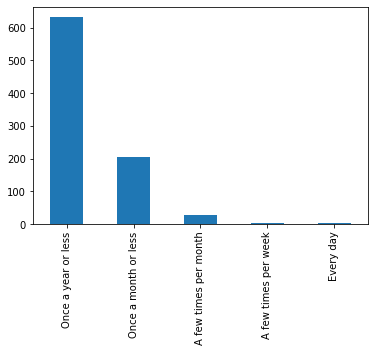

In [ ]:
df_flying_etiquette["How often do you travel by plane?"].value_counts().plot.bar()

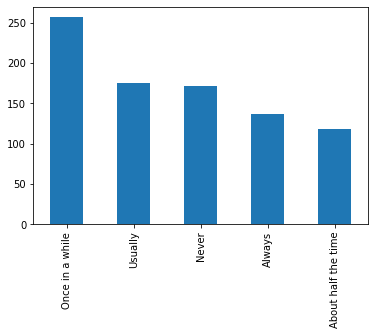

In [ ]:
df_flying_etiquette["Do you ever recline your seat when you fly?"].value_counts().plot.bar()

#Slide 8: Relationship Between Height and Reclining Seat

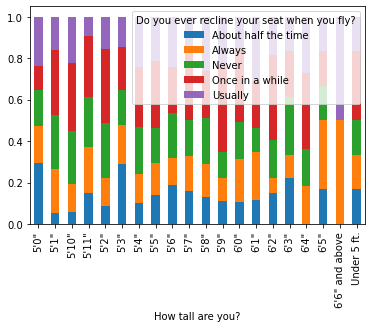

In [ ]:
joint_recline_height = pd.crosstab(df_flying_etiquette["Do you ever recline your seat when you fly?"], df_flying_etiquette["How tall are you?"], 
                                    normalize=True)
height_marginal = joint_recline_height.sum(axis=0)
recline_marginal = joint_recline_height.sum(axis=1)
cond_recline_height = joint_recline_height.divide(height_marginal, axis=1)
cond_recline_height.T.plot.bar(stacked=True)

#Slide 9: Arrivals and Departures

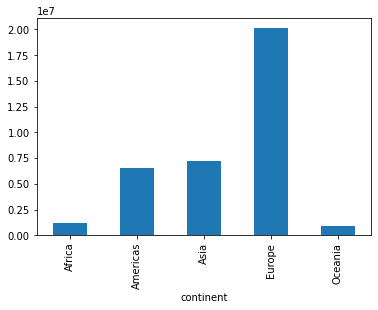

In [ ]:
(df_international_tourism.groupby("continent")["number_of_arrivals"].mean().plot.bar())

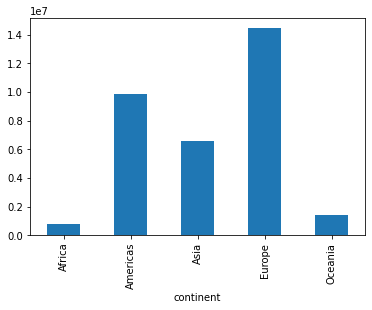

In [ ]:
(df_international_tourism.groupby("continent")["number_of_departures"].mean().plot.bar())

#Slide 10: Number of Arrivals: Dot Map

In [ ]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_covid = df_covid[["Country/Region", "Lat", "Long"]]
df_covid = df_covid.rename(columns={"Country/Region": "Country Name"})

In [ ]:
df_dot_map = df_international_tourism
df_dot_map = df_dot_map.merge(df_covid, on="Country Name", how="left")

In [ ]:
df_dot_map = df_dot_map[df_dot_map["number_of_arrivals"].notna()]
df_dot_map = df_dot_map[df_dot_map["year"] == 2017]

px.scatter_geo(df_dot_map, lat = "Lat", lon = "Long",
               hover_name = "Country Name",
               size = df_dot_map["number_of_arrivals"])

#Slide 12: KNN Model: Flying Etiquette Data

In [ ]:
df_flying_etiquette = df_flying_etiquette.dropna().reset_index(drop=True)

In [ ]:
def feet_to_inches(s) -> int:
  if s == "Under 5 ft.":
    return 60
  if s == "6'6\" and above":
    return 78
  lst = s.split(sep = "'")
  feet = int(lst[0])
  inches = int(lst[1][:-1])
  return 12 * feet + inches

In [ ]:
df_flying_etiquette["Height"] = df_flying_etiquette.apply(lambda row: feet_to_inches(row["How tall are you?"]), axis=1) 

In [ ]:
df_flying_etiquette["Do you ever recline your seat when you fly?"].value_counts()

Once in a while        199
Usually                154
Never                  129
Always                 112
About half the time     93
Name: Do you ever recline your seat when you fly?, dtype: int64

In [ ]:
df_flying_etiquette = df_flying_etiquette[["Do you ever recline your seat when you fly?",
                                          "Height",
                                          "Age"]].dropna().reset_index(drop=True)

In [ ]:
X_train = df_flying_etiquette[["Height",
                                "Age"]]
y_train = df_flying_etiquette["Do you ever recline your seat when you fly?"]

In [ ]:
ct_flyet = make_column_transformer(
    (OneHotEncoder(sparse=False), ["Height",
                               "Age"]),
    remainder='passthrough'
)

knn_model = make_pipeline(
    ct_flyet,
    KNeighborsClassifier(n_neighbors=5)
)

knn_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Height', 'Age'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

**Accuracy**

In [ ]:
cv_scores = cross_val_score(knn_model, X_train, y_train, 
                            cv=10, scoring="accuracy")
cv_scores.mean()

0.23437766410912192

#Slide 13: KNN Model: Flying Etiquette Data cont.

In [ ]:
def recline_binary(s) -> int:
  if s == "Never":
    return "No"
  return "Yes"

In [ ]:
df_flying_etiquette_binary = df_flying_etiquette.copy()
df_flying_etiquette_binary["Recline"] = df_flying_etiquette.apply(lambda row: recline_binary(row["Do you ever recline your seat when you fly?"]), axis=1) 

In [ ]:
df_flying_etiquette_binary["Recline"].value_counts()

Yes    558
No     129
Name: Recline, dtype: int64

In [ ]:
df_flying_etiquette_binary = df_flying_etiquette_binary[["Recline",
                                               "Height",
                                               "Age"]].dropna().reset_index(drop=True)

In [ ]:
X_train = df_flying_etiquette_binary[["Height",
                                          "Age"]]
y_train = df_flying_etiquette_binary["Recline"]

In [ ]:
ct_flyet = make_column_transformer(
    (OneHotEncoder(sparse=False), ["Height",
                               "Age"]),
    remainder='passthrough'
)

knn_model = make_pipeline(
    ct_flyet,
    KNeighborsClassifier(n_neighbors=5)
)

knn_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Height', 'Age'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
grid_search = GridSearchCV(
    knn_model,
    param_grid={"kneighborsclassifier__n_neighbors": range(1, 50)},
    scoring="accuracy",
    cv=10
)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 21}

In [ ]:
knn_model = make_pipeline(
    ct_flyet,
    KNeighborsClassifier(n_neighbors=21)
)

knn_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Height', 'Age'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=21))])

In [ ]:
cv_scores = cross_val_score(knn_model, X_train, y_train, 
                            cv=10, scoring="accuracy")
cv_scores.mean()

0.8136828644501278

#Slide 14: Testing out the model on ourselves

In [ ]:
# define the test data (recall that scikit-learn expects a 2D-array)
x_new = pd.DataFrame(columns=["Height",
                              "Age"])
x_new.loc[0] = [63, "18-29"]
x_new.loc[1] = [69, "18-29"]
knn_model.predict(x_new)

array(['Yes', 'Yes'], dtype=object)

#Slide 15: Ensemble Model: International Tourism

In [ ]:
df_international_tourism = pd.read_csv(data_dir + "df_international_tourism.csv")
df_international_tourism = df_international_tourism[df_international_tourism["year"] >= 1995]

In [ ]:
df_2017 = df_international_tourism[df_international_tourism["year"] == 2017]
df_2017 = df_2017.dropna(subset=["receipts_percent_total_exports", "number_of_departures", "expenditures_passenger_transport_items"]) #dropped two countries where there were missing values in the variables we are interested in
df_2017.dropna(axis='columns')

,Country Name,year,total_gdp,population,income_per_person,co2_emissions,receipts_percent_total_exports,receipts_travel_items,receipts_current_us,number_of_departures,number_of_arrivals,expenditures_passenger_transport_items,expenditures_percent_total_imports,expenditures_current_us
9977,Albania,2017,1.270000e+10,2880000.0,13300.0,1.590,49.471563,1.943000e+09,2.050000e+09,5.186000e+06,5.118000e+06,4.000000e+07,24.058987,1.473000e+09
9980,Argentina,2017,5.830000e+11,44400000.0,22700.0,4.410,7.860525,5.370000e+09,5.830000e+09,2.158300e+07,6.711000e+06,2.802000e+09,15.877179,1.418000e+10
9981,Armenia,2017,1.200000e+10,2950000.0,12700.0,1.890,27.760742,1.204000e+09,1.224000e+09,1.482000e+06,1.495000e+06,5.500000e+07,21.555388,1.218000e+09
9983,Australia,2017,1.460000e+12,24900000.0,49000.0,16.900,14.820693,4.174700e+10,4.397500e+10,1.093200e+07,8.815000e+06,5.240000e+09,13.699768,3.971000e+10
9984,Austria,2017,4.080000e+11,8890000.0,55300.0,7.750,9.949776,2.033300e+10,2.242400e+10,1.149100e+07,2.946000e+07,2.110000e+09,6.048804,1.287800e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10141,United States,2017,1.960000e+13,327000000.0,61600.0,16.600,9.777483,1.964680e+11,2.337580e+11,1.480450e+08,1.742918e+08,4.035800e+10,5.451567,1.582870e+11
10142,Uzbekistan,2017,1.000000e+11,32500000.0,7080.0,2.810,6.727242,6.890000e+08,8.350000e+08,5.182000e+06,2.690000e+06,4.760000e+08,12.792844,2.107000e+09
10145,Vanuatu,2017,8.370000e+08,293000.0,3090.0,0.529,75.540795,2.650000e+08,2.890000e+08,2.630000e+04,3.327000e+05,3.000000e+06,4.033783,1.900000e+07
10146,Samoa,2017,8.500000e+08,196000.0,6390.0,1.320,59.987355,1.660000e+08,1.670000e+08,5.500000e+04,1.580000e+05,7.000000e+05,0.950797,3.900000e+06


In [ ]:
# calculate estimate of test error for a given feature set
def get_cv_error(features):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=5)
  )
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=df_2017[features], 
                             y=df_2017["co2_emissions"],
                             scoring="neg_mean_squared_error", cv=3)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [["income_per_person", "population", "receipts_travel_items"],
                 ["income_per_person", "population", "number_of_departures"],
                 ["income_per_person", "population", "receipts_current_us"],
                 ["income_per_person", "population", "receipts_percent_total_exports"],
                 ["income_per_person", "population", "expenditures_percent_total_imports"]]:
  errs[str(features)] = get_cv_error(features)

errs

<ipython-input-43-4dcc10afb33d>:16: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



['income_per_person', 'population', 'receipts_travel_items']                 13.419724
['income_per_person', 'population', 'number_of_departures']                  14.287091
['income_per_person', 'population', 'receipts_current_us']                   13.677253
['income_per_person', 'population', 'receipts_percent_total_exports']        13.551865
['income_per_person', 'population', 'expenditures_percent_total_imports']    13.893469
dtype: float64

#Slide 16: Ensemble Model: International Tourism cont.

In [ ]:
X_train = df_2017[["income_per_person", "population", "receipts_travel_items"]]
y_train = df_2017["co2_emissions"]

In [ ]:
linear_model = make_pipeline(
    LinearRegression()
)

linear_model.fit(X=X_train, y=y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=3)
)
knn_model.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=3))])

In [ ]:
ensemble_model = VotingRegressor([
    ("linear", linear_model), 
    ("knn", knn_model)
])
ensemble_model.fit(X=X_train, y=y_train)

VotingRegressor(estimators=[('linear',
                             Pipeline(steps=[('linearregression',
                                              LinearRegression())])),
                            ('knn',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('kneighborsregressor',
                                              KNeighborsRegressor(n_neighbors=3))]))])

In [ ]:
for model in [linear_model, knn_model, ensemble_model]:
    print(-cross_val_score(model, X=X_train, y=y_train, cv=5,
                           scoring="neg_mean_squared_error").mean())

12.295825712894542
14.982486225396823
11.767698616704475


In [ ]:
# get model's predictions on validation set
y_predict = ensemble_model.predict(X_train)

# calculate RMSE on validation set
rmse = np.sqrt(mean_squared_error(y_train, y_predict))
rmse

2.721978072758195